# Moving Averages CINGULATE region

### 1) Imports

In [40]:
import os
import glob
import sys
import json

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [ ]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [ ]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [ ]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

In [ ]:
# def process_config(config) -> DictConfig:
#     """Does whatever operations on the config file
#     """

#     print(OmegaConf.to_yaml(config))
#     print("Working directory : {}".format(os.getcwd()))
#     config.input_size = eval(config.input_size)
#     print("config type: {}".format(type(config)))
#     return config

In [ ]:
# from hydra.core.global_hydra import GlobalHydra
# model_dir = 'Runs/28_cingulate_back_to_2mm/Output/t-0.1/n-004_o-4'

# GlobalHydra.instance().clear()
# # Initialize hydra
# initialize(config_path=f"{model_dir}/.hydra")
# # compose from config.yaml, this composes a bunch of defaults in:
# config=compose(config_name="config.yaml")
# config = process_config(config)

In [37]:
# We load the mebeddings
result_dir = '/host/volatile/jc225751/Runs/28_cingulate_back_to_2mm/Output/t-0.1/n-004_o-4'
val_embeddings_file = f"{result_dir}/val_embeddings.pt"
embeddings = torch.load(val_embeddings_file)
print(embeddings.shape)

torch.Size([110, 4])


In [42]:
# We load the labels
with open(f"{result_dir}/val_filenames.json", 'r') as f:
    labels = json.load(f)
print(labels)

['145834', '587664', '233326', '140925', '113215', '102008', '122418', '141826', '656657', '150019', '157336', '692964', '190132', '144933', '168745', '675661', '123925', '217126', '707749', '715950', '378756', '268850', '804646', '137936', '910241', '104820', '723141', '165436', '138231', '943862', '784565', '198653', '197449', '173233', '877269', '166640', '725751', '150625', '627549', '880157', '173435', '529953', '144125', '664757', '421226', '127933', '221218', '100610', '825654', '168139', '171633', '397154', '141422', '869472', '114318', '227533', '818859', '748662', '185846', '361941', '172130', '588565', '129129', '156435', '211922', '189349', '115320', '134728', '159845', '106521', '552544', '163331', '700634', '113821', '134627', '107725', '167440', '126325', '169141', '154229', '133928', '145127', '136227', '227432', '131217', '168240', '562446', '325129', '571548', '164030', '686969', '150928', '871762', '182032', '966975', '113316', '753150', '121921', '792766', '286347',

In [48]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_
clusters_centroids = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(embeddings, cluster_labels)}")


clusters centroids = (2, 4)
Average silhouette score: 0.4480094611644745


In [50]:
dstrb_sub = pd.DataFrame(embeddings.numpy(), index=labels, columns=[1, 2, 3, 4])
dstrb_sub['cluster_lab'] = cluster_labels

In [51]:
dstrb_sub.head()

,1,2,3,4,cluster_lab
145834,-1.102997,6.063592,11.192781,5.579839,0
587664,-0.989749,1.439369,-0.764728,5.886118,1
233326,-0.801902,7.309334,10.075326,7.100291,0
140925,-0.840939,4.757116,5.218879,2.073957,1
113215,-1.313898,5.444936,3.234003,8.068856,1


In [52]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-1.32936707  6.45413204 11.57266074  8.70867575]
 [-1.1666423   3.49686977  4.44863651  4.60448636]]


In [53]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

Closest subject to centroid of cluster 1 is 113316
Closest subject to centroid of cluster 2 is 144125


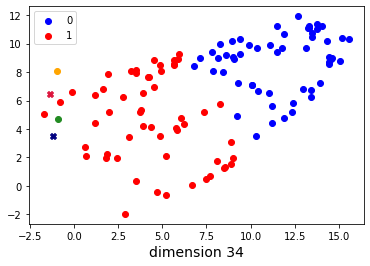

In [61]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[2:4]]) for i in range(len(dstrb_sub))])

color_dict = {1: 'red', 0:'blue'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(dstrb_sub[1]['113316'], dstrb_sub[2]['113316'], color='orange')
ax.scatter(dstrb_sub[1]['144125'], dstrb_sub[2]['144125'], color='forestgreen')

plt.xlabel(f'dimension 3', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.legend()
plt.show()

In [ ]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)

### Creation of buckets dictionnary

In [ ]:
def create_bucket(vol):
    arr = np.asarray(vol)

    # Threshold and "binarize"
    arr[np.where(arr > 1)]=1
    # Writes volume
    temp_dir = '/tmp/'
    threshold_filename = f'{temp_dir}/temp_threshold.nii.gz'
    aims.write(vol, threshold_filename)
    # Save to bucket file
    bucket_filename = f"{temp_dir}/temp_bucket.bck"
    cmd = f"AimsFileConvert -c Bucket -t VOID -e 1 -i {threshold_filename} -o {bucket_filename}"
    os.system(cmd)
    # Displays bucket file
    bucket, bucket_raw, dxyz, rot, tr = ma.load_bucket(bucket_filename)
    m = dtx.convert.bucket_to_mesh(bucket)
    cmd = f"rm {threshold_filename} {threshold_filename+'.minf'} {bucket_filename} {bucket_filename+'.minf'}"
    os.system(cmd)
    
    return bucket, m

In [ ]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'
suffix_path = '_normalized.nii.gz'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket, m = create_bucket(bucket)
    bucket = np.asarray(bucket)
    buckets[sub] = bucket

In [ ]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    #bucket, m = create_bucket(bucket)
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

In [ ]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [ ]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)

In [ ]:
aligned_buckets = aligned_buckets_C1
aligned_buckets.update(aligned_buckets_C2)

In [ ]:
plt.hist(cluster1[1])

In [ ]:
plt.hist(cluster2[1])

In [ ]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [ ]:
MA_coords = get_MA_coords(cluster1, 1, num_subj_threshold=14)
step = step = MA_coords[1]-MA_coords[0]

In [ ]:
MA_coords

In [ ]:
step

In [ ]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets_C1, cluster1, axis_n=1, FWHM=step)

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.6, threshold="85%")
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster33.mesh")#### Saving of average crops

### Whole cluster analysis

In [ ]:
clusters_centroids

In [ ]:
np.mean(clusters_centroids,axis=0)

In [ ]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")
centroid = np.mean(clusters_centroids, axis=0)
print(centroid)

central = closest_distance(centroid, dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster is {central}")
print(dstrb_sub[1][str(central)], dstrb_sub[2][str(central)])

In [ ]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central)

In [ ]:
MA_coords = get_MA_coords(dstrb_sub, 1, num_subj_threshold=14)
step = step = MA_coords[1]-MA_coords[0]

In [ ]:
MA_coords

In [ ]:
step

In [ ]:
len(dstrb_sub)

In [ ]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets, dstrb_sub, axis_n=1, FWHM=0.4)

In [ ]:
cld.draw(list(SPAM_vols.values())[-1], th_min=0.3)

In [ ]:
cld.draw(list(SPAM_vols.values())[0], th_min=0.3)

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=1, threshold=0.45,deciReductionRate=0, smoothRate=0.25)
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=75)

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster44.mesh")#### Saving of average crops

In [ ]:
fig = cld.draw(list(SPAM_vols.values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes.values())[0], fig=fig)

In [ ]:
SPAM_centers_c2 = [0]
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=1, FWHM=1)

In [ ]:
SPAM_meshes2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.8)
    
shifted_SPAM_meshes2 = {}
for dist, mesh in SPAM_meshes2.items():
    shifted_SPAM_meshes2[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

#### Visualization of average crops of both clusters

In [ ]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

In [ ]:

for x, mesh in tqdm(shifted_SPAM_meshes2.items()):
    aims.write(mesh, f"MA_{x}_2cluster2.mesh")

### 5) 2 clusters analysis

#### Loading of subjects of the two clusters

In [ ]:
tsne_subjects = pd.read_csv('tsne_asym_bench_sc.csv', index_col="id_sub").drop(columns={'Unnamed: 0'})
subjects_tsne = tsne_subjects.index
tsne_subjects = tsne_subjects.rename(columns={'tsne: 0': 0, 'tsne: 1': 1})
tsne_subjects.head()

We can use labels if we have them (in the case where we use benchmark subjects vs controls for example):

In [ ]:
color_dict = {'normal_test': 'blue', 'benchmark': 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)
for g in np.unique([tsne_subjects.label]):
    ix = np.where(tsne_subjects.label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'1st most important feature: {tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'2nd most important feature: {tsne_subjects.columns[1]}', fontsize=14)
plt.show()

We can also imagine a case where we don't have any labels but two clusters and apply a kmeans algorithm:

In [ ]:
from sklearn.cluster import KMeans

X = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

labels = kmeans.labels_
tsne_subjects['kmeans_label'] = labels
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

In [ ]:
color_dict = {1: 'blue', 0: 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)

for g in np.unique(kmeans.labels_):
    ix = np.where(kmeans.labels_ == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(tsne_subjects[0][116726], tsne_subjects[1][116726], color='forestgreen')
ax.scatter(tsne_subjects[0][163836], tsne_subjects[1][163836], color='forestgreen')


plt.xlabel(f'{tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'{tsne_subjects.columns[1]}', fontsize=14)
plt.show()

#### Central subjects for both clusters:

In [ ]:
central_1 = closest_distance(clusters_centroids[0], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

We create sub-dataframes based on labels

In [ ]:
cluster1 = tsne_subjects[tsne_subjects.kmeans_label==0]
cluster2 = tsne_subjects[tsne_subjects.kmeans_label==1]
assert(len(np.unique(list(cluster1.kmeans_label)))==1)
assert(len(np.unique(list(cluster2.kmeans_label)))==1)

#### Creation of buckets dictionnary

In [ ]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [ ]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1, cores=2)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2, cores=2)

In [ ]:
sns.displot(cluster1, x=0)

In [ ]:
sns.displot(cluster2, x=0)

In [ ]:
SPAM_centers_c1 = [0]
SPAM_vols_c1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=0, FWHM=1)

In [ ]:
SPAM_centers_c2 = [4.5]
SPAM_vols_c2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=0, FWHM=1)

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]+list(SPAM_vols_c2.items())[:]):
    SPAM_meshes[k]=cld.aims_tools.volume_to_mesh(
                    volume=volume, smoothingFactor=1.4,
                    aimsThreshold="90%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

#### Visualization of average crops of both clusters

In [ ]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

#### Saving of average crops

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster.mesh")